In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib import cm
import os

In [2]:
covid_preds_resampled = np.load("../../output/exp_covid/smc_t/smc_t_d32_p60/1/resampled_particles_preds_test.npy")
covid_preds_resampled_10p = np.load("../../output/exp_covid/smc_t/smc_t_d32_p10/1/resampled_particles_preds_test.npy")

In [3]:
covid_preds_resampled.shape

(89, 60, 60, 1)

In [4]:
covid_truth = np.load("../../data/covid/test/covid.npy")
covid_truth = covid_truth[:,:-1,:]
covid_truth.shape

(89, 60, 1)

In [5]:
def get_unique_arrays(array, index):
    array = np.squeeze(array)
    list_unique_arrays = []
    list_indexes = []
    list_counts = []
    arr = array[index]
    #arr = arr[np.newaxis,:,:,:]
    #else:
        #arr = array
    num_timesteps = array.shape[2]
    for t in range(num_timesteps):
        unique_arr, indexes, counts = np.unique(arr[:,t], return_index=True, return_counts=True)
        list_unique_arrays.append(unique_arr)
        list_indexes.append(indexes)
        list_counts.append(counts)
    return list_unique_arrays, list_indexes, list_counts

In [17]:
def get_mean_num_particles(array):
    all_counts = np.zeros(shape=(array.shape[0], array.shape[2]))
    for index in range(array.shape[0]):
        arr,_,_ = get_unique_arrays(array, index)
        num_unique_particles = [ar.shape[0] for ar in arr]
        all_counts[index] = np.array(num_unique_particles)
    return np.round(np.mean(all_counts, axis=0)), np.std(all_counts, axis=0)

In [18]:
mean_60, std_60 = get_mean_num_particles(covid_preds_resampled)
mean_10, std_10 = get_mean_num_particles(covid_preds_resampled_10p)
means = [mean_60]
stds = [std_60]

In [49]:
mean_60[:10]

array([2., 2., 2., 2., 2., 3., 3., 3., 3., 3.])

In [26]:
mean_10.dtype

dtype('float64')

In [27]:
std_10.dtype

dtype('float64')

In [33]:
reverse_10 = np.array(list(reversed(mean_10)))

In [34]:
reverse_10.dtype

dtype('float64')

In [35]:
low_b = reverse_10 - 1.87 * np.array(list(reversed(std_10)))

In [24]:
low_b = [float(m) for m in list(reversed(mean_10))]-1.87*list(reversed(std_10))

TypeError: can't multiply sequence by non-int of type 'float'

In [52]:
reversed_mean = np.array(list(reversed(mean_60)))
reversed_mean[:10]

array([39., 28., 23., 19., 16., 14., 13., 12., 11., 10.])

In [57]:
def plot_statistics(mean, std, color='blue'):
    fig, ax = plt.subplots(figsize=(7, 5))
    x = np.linspace(-1,-mean.shape[0],mean.shape[0])
    #x = np.linspace(1,mean.shape[0],mean.shape[0])
    ax.set_xlim(-1, -60)
    reversed_mean = np.array(list(reversed(mean)))
    reversed_std = np.array(list(reversed(std)))
    low_b = reversed_mean-1.87*reversed_std
    upper_b = reversed_mean+1.87*reversed_std
    ax.plot(x, reversed_mean, color=color, alpha=0.8)
    ax.fill_between(x, low_b, upper_b, alpha=0.3, facecolor=color, edgecolor=color)
    ax.hlines(30, -1, -60, colors=color, linestyles='dashed', label='half line')
    #ax.hlines(30, 1, 60, colors=color, linestyles='dashed', label='half line')
    ax.hlines(10, -1, -60, colors=color, linestyles='dotted', label='1/6 line')
    #ax.hlines(10, 1, 60, colors=color, linestyles='dotted', label='1/6 line')
    ax.legend(fontsize=14, loc='upper left')
    #ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.set_xlabel("timesteps", size=14)
    ax.set_ylabel("unique particles per timestep", size=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14, labelright=True)
    ax.grid('on', alpha=0.5)
    fig.tight_layout()
    plt.savefig(os.path.join("../../output/plots", "particles_analysis_60p_covid.pdf"), bbox_inches="tight")

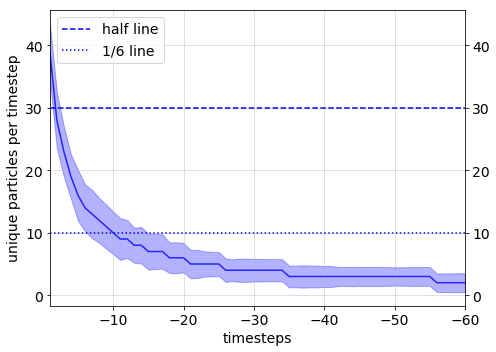

In [58]:
plot_statistics(mean_60, std_60)

In [ ]:
def plot_resampled_particles(array, all_counts, truth=None, factor=1.5):
    #index = np.random.randint(0,array.shape[0])
    index = 28
    unique_arr, indexes, counts = get_unique_arrays(array, index)
    num_unique_particles = [arr.shape[0] for arr in unique_arr]
    evenly_spaced_interval = np.linspace(0, 1, unique_arr[-1].shape[0])
    colors = [cm.rainbow(x) for x in evenly_spaced_interval]
    fig, ax = plt.subplots(figsize=(12, 7))
    x = np.linspace(1,len(unique_arr),len(unique_arr))
    ax.tick_params(axis='y', labelcolor='slateblue')
    ax.set_ylabel("scatter of particles values", color='slateblue', fontsize=14)
    ax2 = ax.twinx() 
    ax2.set_ylabel('number of unique particles', color='grey', fontsize=14)
    for t in range(len(unique_arr)):
        num_p = unique_arr[t].shape[0]
        for idx, col in enumerate(colors[:num_p]):
            ax.scatter(t+1,unique_arr[t][idx], c=col, s=(counts[t][idx])*factor, alpha=0.5)
    #ax2.scatter(x, num_unique_particles, color='grey', alpha=0.7, marker='_', linewidth=4)
    #ax2.plot(x, num_unique_particles, color='grey', alpha=0.7)
    if truth is not None:
        truth = np.squeeze(truth[index])
        ax.scatter(x, truth, color='black', marker='x', linewidth=3)
    ax2.bar(x, num_unique_particles, color='grey', alpha=0.2, label='number of unique particles for idx test {}'.format(index))
    ax2.plot(x, all_counts, color='dimgrey', marker='o', linestyle='dotted', label='mean of number of unique particles over test set', alpha=0.8)
    ax2.tick_params(axis='y', labelcolor='dimgrey')
    ax2.legend(fontsize=13)
    ax.grid('on', alpha=0.5)
    fig.tight_layout()
    print("idx test", index)
    #plt.show()
    fig.savefig(os.path.join("../../output/plots", "particles_covid_idx28.png"), bbox_inches="tight")

In [ ]:
def plot_resampled_particles_multiple(array, truth, factor=1.5):
    fig, axes = plt.subplots(2,2,figsize=(30, 15))
    evenly_spaced_interval = np.linspace(0, 1, array.shape[2])
    colors = [cm.rainbow(x) for x in evenly_spaced_interval]
    x = np.linspace(1,array.shape[2],array.shape[2])
    for i in range(2):
        for j in range(2):
            ax = axes[i][j]
            #index = np.random.randint(0,array.shape[0])
            index = 27
            truth_i = np.squeeze(truth[index])
            unique_arr, indexes, counts = get_unique_arrays(array, index)
            num_unique_particles = [arr.shape[0] for arr in unique_arr]
            #evenly_spaced_interval = np.linspace(0, 1, unique_arr[-1].shape[0])
            #colors = [cm.rainbow(x) for x in evenly_spaced_interval]
            #x = np.linspace(1,len(unique_arr),len(unique_arr))
            ax.tick_params(axis='y', labelcolor='slateblue')
            ax.set_ylabel("scatter of particles values", color='slateblue', size=14)
            ax2 = ax.twinx() 
            ax2.set_ylabel('number of unique particles', color='grey')
            for t in range(len(unique_arr)):
                num_p = unique_arr[t].shape[0]
                for index, col in enumerate(colors[:num_p]):
                    ax.scatter(t+1,unique_arr[t][index], c=col, s=(counts[t][index])*factor, alpha=0.5)
            #ax2.scatter(x, num_unique_particles, color='grey', alpha=0.7, marker='_', linewidth=4)
            #ax2.plot(x, num_unique_particles, color='grey', alpha=0.7)
            ax.scatter(x, truth_i, color='black', marker='x', linewidth=3)
            ax2.bar(x, num_unique_particles, color='grey', alpha=0.1)
            ax2.tick_params(axis='y', labelcolor='grey')
    fig.tight_layout()

In [ ]:
plot_resampled_particles(covid_preds_resampled, all_counts, covid_truth, factor=6) #27, 28 37, 49, 87, 80, 53 is a good index.

In [ ]:
plot_resampled_particles(covid_preds_resampled, covid_truth)

In [ ]:
plot_resampled_particles(covid_preds_resampled, covid_truth)

In [ ]:
#plot_resampled_particles_multiple(covid_preds_resampled, covid_truth)

In [ ]:
#plot_resampled_particles(synthetic_1_preds_resampled, synthetic_truth, factor=3.5)